# What's MCP

## 相关网站
[MCP 官网](https://modelcontextprotocol.io) （https://modelcontextprotocol.io）


[开箱即用 MCP Server](https://github.com/modelcontextprotocol/servers)  (https://github.com/modelcontextprotocol/servers)


[MCP (Model Context Protocol)，一篇就够了。](https://zhuanlan.zhihu.com/p/29001189476)

[Semantic Kernel × MCP：智能体的上下文增强探索](https://zhuanlan.zhihu.com/p/29873458590)


[MCP Servers 收录网站1](https://mcpservers.org)

[MCP Servers 收录网站2](https://mcp.so)


## 定义
MCP（Model Context Protocol，模型上下文协议）是由Anthropic在2024年底推出的协议，用来标准化AI模型与外部数据源和工具的交互。
**使得开发者能够以一致的方式将各种数据源、工具和功能连接到 AI 模型。**

本质上是一种协议：Agent 开发共同约定的技术规范
目的是提升Agent的开发效率

解决了：
Agent开发中调用外部工具的技术门槛过高的问题

大模型能调用外部工具是进化为智能体的关键



就像 USB-C 让不同设备能够通过相同的接口连接一样，**MCP 堪称 AI Agent时代的 USB-C。**


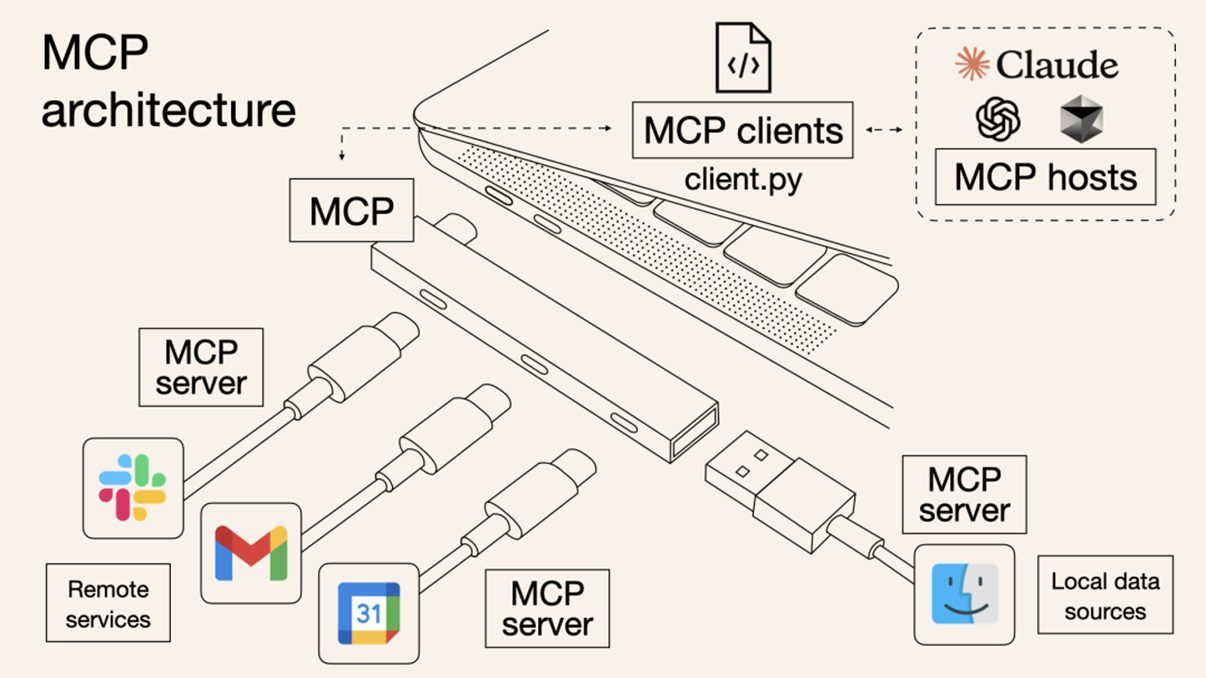


MCP 的目标是创建一个通用标准，使 AI 应用程序的开发和集成变得更加简单和统一。

## 核心组件

MCP 基于C/S架构，一个Host可以运行多个MCP 客户端。这种架构使用户能够跨应用程序集成AI功能，同时保持清晰的安全边界和关注点隔离。MCP基于JSON-RPC构建，提供了一个专注于客户端和服务器之间上下文交换和采样协调的有状态会话协议。

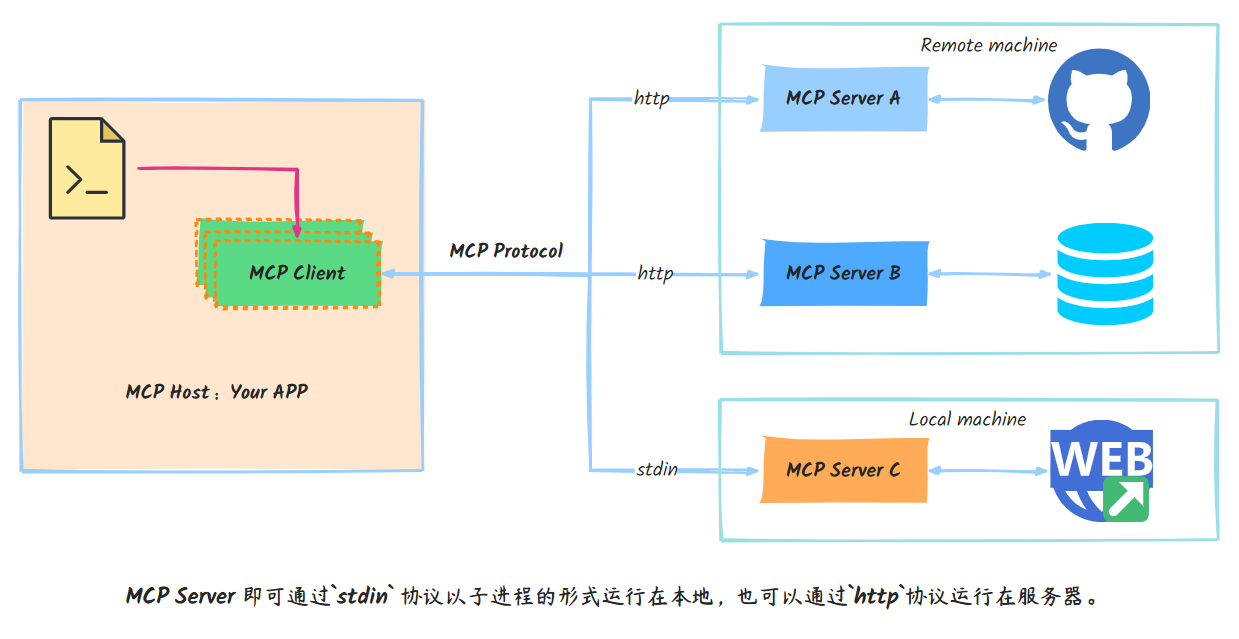

**MCP Host**：也就是我们的AI 应用
* 创建和管理多个MCP 客户端
* 协调AI，MCP，SK
* 管理跨客户端的上下文聚合

**MCP Clinet**：
* 由MCP Host 创建，与特定MCP Server 保持一对一有状态连接
* 进行双向的消息路由
* 管理订阅和通知

**MCP Server**：
* 暴露Resources、Tools和Prompt
* 可以以Host的子进程在本地运行或远程服务形式运行



## Tools

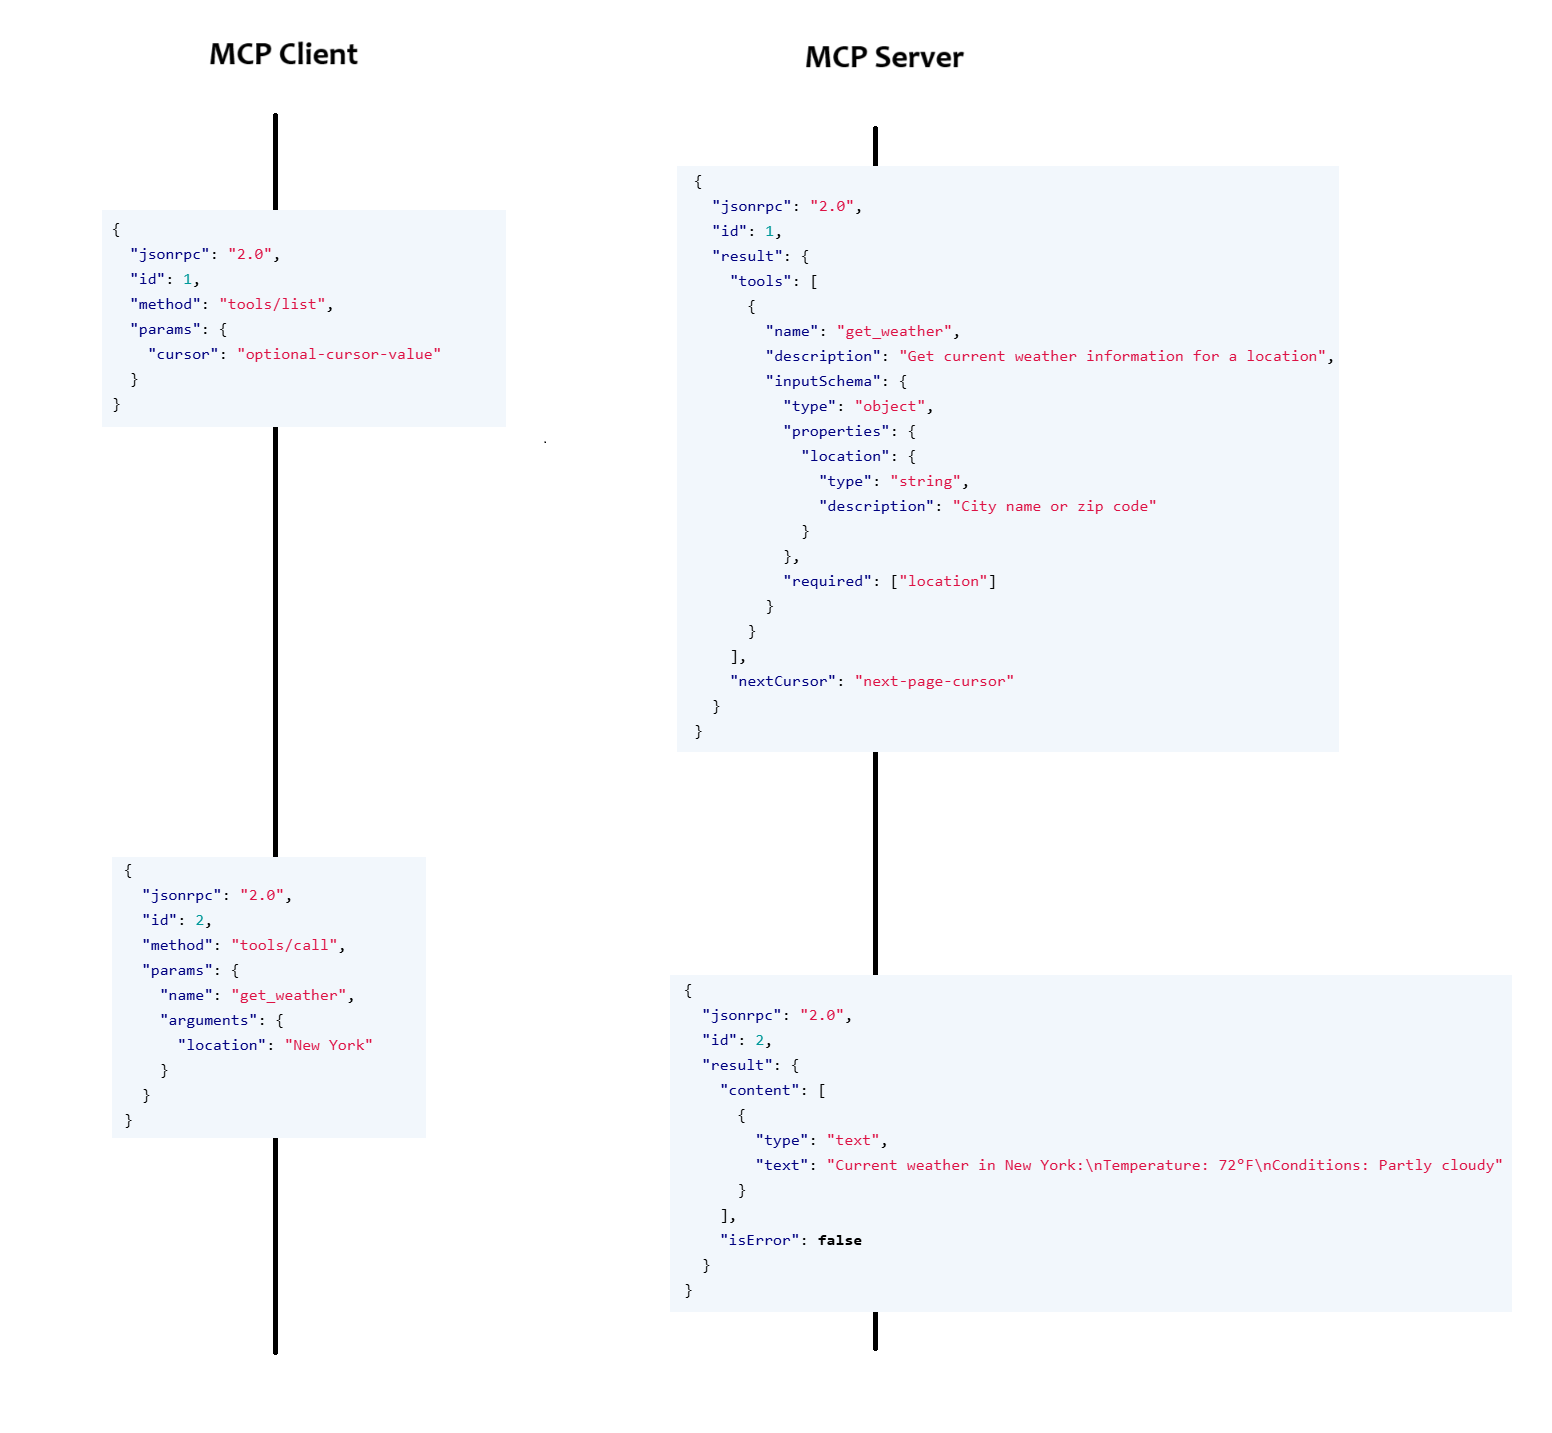

In [1]:
sequenceDiagram
    participant LLM
    participant Client
    participant Server

    Note over Client,Server: Discovery
    Client->>Server: tools/list
    Server-->>Client: List of tools

    Note over Client,LLM: Tool Selection
    LLM->>Client: Select tool to use

    Note over Client,Server: Invocation
    Client->>Server: tools/call
    Server-->>Client: Tool result
    Client->>LLM: Process result

    Note over Client,Server: Updates
    Server--)Client: tools/list_changed
    Client->>Server: tools/list
    Server-->>Client: Updated tools

# 理解 Transport

MCP目前为客户端-服务器通信定义了两种标准传输机制：

* stdio
* HTTP with Server-Sent Events (SSE) (将被 Steamable HTTP 替换)

## stdin

* 客户端将 MCP 服务器作为子进程启动。
* 服务器在其标准输入（stdin）上接收 JSON-RPC 消息，并将响应写入其标准输出（stdout）。
* 消息以换行符分隔，并且不得包含嵌入的换行符。
* 服务器可以出于日志记录目的将 UTF-8 字符串写入其标准错误（stderr）。客户端可以捕获、转发或忽略此日志记录.。
* 服务器绝不能向其stdout写入任何不是有效 MCP 消息的内容。
* 客户端绝不能向服务器的stdin写入任何不是有效 MCP 消息的内容。

In [2]:
sequenceDiagram
    participant Client
    participant Server Process

    Client->>+Server Process: Launch subprocess
    loop Message Exchange
        Client->>Server Process: Write to stdin
        Server Process->>Client: Write to stdout
        Server Process--)Client: Optional logs on stderr
    end
    Client->>Server Process: Close stdin, terminate subprocess
    deactivate Server Process